In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential
import torchvision.models as models

In [2]:
class ChannelAttention(nn.Module):
    def __init__(self):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.mlp = Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Linear(128, 2048),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.mlp(self.avg_pool(x).view(x.size(0), -1))
        max_out = self.mlp(self.max_pool(x).view(x.size(0), -1))
        temp = avg_out + max_out

        channel_attention = self.sigmoid(temp)
        return x * channel_attention.view(x.size(0), x.size(1), 1, 1)
    
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv1(concat)
        spatial_attention = self.sigmoid(out)
        return x * spatial_attention

class CBAM(nn.Module):
    def __init__(self):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention()
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x
    
class CrossSAttention(nn.Module):
    def __init__(self):
        super(CrossSAttention, self).__init__()

        self.mlp = Sequential(
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.Linear(64, 1024)
        )

    def forward(self, x, y):
        a = y * F.sigmoid(self.mlp(y))
        return x + a
    
class CANet(nn.Module):
    def __init__(self):
        super(CANet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet =  nn.Sequential(*list(self.resnet.children())[:-2])

        for param in self.resnet.parameters():
                param.requires_grad = False

        self.cbam_dr = CBAM()
        self.cbam_dme = CBAM()

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc_dr = nn.Linear(2048, 1024)
        self.fc_dme = nn.Linear(2048, 1024)

        self.fc_dr_s = nn.Linear(1024, 2)
        self.fc_dme_s = nn.Linear(1024, 3)

        self.cross_dr = CrossSAttention()
        self.cross_dme = CrossSAttention()

        self.fc_dr_r = nn.Linear(1024, 2)
        self.fc_dme_r = nn.Linear(1024, 3)

    def forward(self, x):
        x = self.resnet(x)
        dr = self.cbam_dr(x)
        dme = self.cbam_dme(x)

        dr = self.avg_pool(x).view(dr.size(0), -1)
        dme = self.avg_pool(x).view(dme.size(0), -1)

        dr = self.fc_dr(dr)
        dme = self.fc_dme(dme)

        dr_s = self.fc_dr_s(dr) # self prediction
        dme_s = self.fc_dme_s(dme)

        dr_r = self.cross_dr(dr, dme)
        dme_r = self.cross_dme(dme, dr)

        dr_r = self.fc_dr_r(dr_r) # relation prediction
        dme_r = self.fc_dme_r(dme_r)
        
        return dr_s, dr_r, dme_r, dme_s

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
    
def extract_center_square(image_path):
    img = Image.open(image_path).convert('RGB')

    width, height = img.size
    size = height

    left = (width - size) // 2
    top = (height - size) // 2
    right = (width + size) // 2
    bottom = (height + size) // 2

    center_square = img.crop((left, top, right, bottom))
    return center_square

class CustomDataset(Dataset):
    def __init__(self, file_list_path, fold_path, transform=None):
        self.file_list = self.load_file_list(file_list_path)
        self.transform = transform

    def load_file_list(self, file_list_path):
        with open(file_list_path, 'r') as file:
            file_list = [os.path.join('data', f) for f in file.read().splitlines()]
        # print(file_list[:10])
        return file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = extract_center_square(img_path)
        if self.transform:
            img = self.transform(img)
    
        label = self.get_label_from_path(img_path)
        return img, label

    def get_label_from_path(self, img_path):
        file_name = os.path.basename(img_path)
        directory = os.path.dirname(img_path)
        folder_name = os.path.basename(directory) # Base11...
        df = pd.read_excel(f'{directory}/Annotation {folder_name}.xls')
        
        item = df.iloc[df[df['Image name'] == file_name].index, [2,3]].values[0]

        if item[0] < 2:
            item[0] = 0
        else:
            item[0] = 1
        return item

# dataset = CustomDataset(file_list_path='data/file_list.txt', fold_path='data/10fold', transform=transform)

# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
# example = next(iter(dataloader))

# example[0].shape, example[1].shape

# image_pil = transforms.ToPILImage()(example[0][0])
# plt.imshow(image_pil)

In [4]:
def loss_fn(output, target, criterion=nn.CrossEntropyLoss(), lamb=0.25): # output tuple 4, target 2
    # print(output[0].shape, target[:,0].shape)
    l_dr = criterion(output[0], target[:,0])
    l_dr_r = criterion(output[1], target[:,0])
    l_dme_r = criterion(output[2], target[:,1])
    l_dme = criterion(output[3], target[:,1])

    tot_loss = l_dr_r + l_dme_r + lamb* (l_dr + l_dme)
    return tot_loss

In [5]:
from sklearn.metrics import f1_score, accuracy_score
def eval(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            dr_pred, dme_pred = F.softmax(outputs[1], dim=1), F.softmax(outputs[2], dim=1)

            dr, dme = labels[:, 0].cpu().numpy(), labels[:, 1].cpu().numpy()

            dr_pred_class = torch.argmax(dr_pred, 1).cpu().numpy()
            dme_pred_class = torch.argmax(dme_pred, 1).cpu().numpy()
            
            dr_f1 = f1_score(dr, dr_pred_class, average='weighted')
            dme_f1 = f1_score(dme, dme_pred_class, average='weighted')
            dr_accuracy = accuracy_score(dr, dr_pred_class)
            dme_accuracy = accuracy_score(dme, dme_pred_class)

    model.train()
    return dr_f1, dme_f1, dr_accuracy, dme_accuracy

/home/ipweb/miniconda3/envs/zml/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [6]:
def load_new_model():
    pass

In [7]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data.dataset import random_split
from new_model import CANet_reg

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

load_model = True
save_model = True

lr = 3e-4
lamb = 0.25
num_epochs = 1000
batch_size = 540

# setting up tensorboard
writer = SummaryWriter("runs/exp3")
step = 0

best_epoch_loss = float('inf')

transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
        ])

dataset = CustomDataset(file_list_path='data/file_list.txt', fold_path='data/10fold', transform=transform)

total_size = len(dataset)
train_size = int(0.9 * total_size)

train_dataset, test_dataset = random_split(dataset, [train_size, total_size - train_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# model = CANet().to(device)
model = CANet_reg().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs*len(train_loader))

if load_model:
    print("=> Loading checkpoint")
    checkpoint = torch.load("saves/exp3/my_checkpoint.pth.tar")
    # saved_state_dict = checkpoint["state_dict"]
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"]) # remove when 
    step = checkpoint["step"]
    print("=> Checkpoint loaded")
    
# print(model)
'''
new_state_dict = new_model.state_dict()
for name, param in saved_state_dict.items():
    if name in new_state_dict and param.size() == new_state_dict[name].size():
        new_state_dict[name].copy_(param)

for name, module in new_model.named_modules():
    if 'cbam_dr.spatial_attention.bn' in name or 'cbam_dme.spatial_attention.bn' in name:
        nn.init.constant_(module.weight, 1.0)
        nn.init.constant_(module.bias, 0.0)

new_model.load_state_dict(new_state_dict)

print(new_model)
new_model.train()


print("=> Saving checkpoint")
checkpoint = {
            "state_dict" : new_model.state_dict(),
            "optimizer" : optimizer.state_dict(),
            "step" : step,
        }
torch.save(checkpoint, 'my_checkpoint.pth.tar')
print("=> Checkpoint saved")
'''


for epoch in range(80, num_epochs):
    epoch_loss=0
    for i, (image, label) in enumerate(train_loader):
        image = image.to(device)
        label = label.to(device)
        #forward pass
        pred = model(image)
        loss = loss_fn(pred, label)

        epoch_loss += loss.item()
        #backward pass
        loss.backward()
        writer.add_scalar("Train/Learning rate", scheduler.get_last_lr()[0]:.6f, global_step = step)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        writer.add_scalar("Train/Training_loss", loss.item(), global_step = step)
        step += 1
    
        if (i+1) % 1 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss = {loss.item():.4f}')

    epoch_loss /= len(train_loader)
    dr_f1, dme_f1, dr_accuracy, dme_accuracy = eval(model, test_loader, device)
    writer.add_scalar("Metrics/Val/DR F1", dr_f1, global_step = epoch)
    writer.add_scalar("Metrics/Val/DME F1", dme_f1, global_step = epoch)
    writer.add_scalar("Metrics/Val/DR Accuracy", dr_accuracy, global_step = epoch)
    writer.add_scalar("Metrics/Val/DME Accuracy", dme_accuracy, global_step = epoch)
    # print(f"Epoch {epoch+1}/{num_epochs}, Epoch Loss: {epoch_loss}, DR F1: {dr_f1}, DME F1: {dme_f1}, DR Accuracy: {dr_accuracy}, DME Accuracy: {dme_accuracy}")
    if epoch % 5 == 0:
        dr_f1, dme_f1, dr_accuracy, dme_accuracy = eval(model, train_loader, device)
        writer.add_scalar("Metrics/Train/DR F1", dr_f1, global_step = epoch)
        writer.add_scalar("Metrics/Train/DME F1", dme_f1, global_step = epoch)
        writer.add_scalar("Metrics/Train/DR Accuracy", dr_accuracy, global_step = epoch)
        writer.add_scalar("Metrics/Train/DME Accuracy", dme_accuracy, global_step = epoch)

    if epoch_loss < best_epoch_loss and save_model:
        best_epoch_loss = epoch_loss
        print(f"Saving best model with loss: {best_epoch_loss}")
        checkpoint = {
            "state_dict" : model.state_dict(),
            "optimizer" : optimizer.state_dict(),
            "step" : step,
        }
        print("=> Saving checkpoint")
        torch.save(checkpoint, 'my_checkpoint.pth.tar')
        print("=> Checkpoint saved")


/home/ipweb/miniconda3/envs/zml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ipweb/miniconda3/envs/zml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


=> Loading checkpoint
=> Checkpoint loaded
epoch 81/1000, step 1/2, loss = 0.9814
epoch 81/1000, step 2/2, loss = 0.9611
Saving best model with loss: 0.9712652564048767
=> Saving checkpoint
=> Checkpoint saved
epoch 82/1000, step 1/2, loss = 0.9917
epoch 82/1000, step 2/2, loss = 0.9862
epoch 83/1000, step 1/2, loss = 0.9786
epoch 83/1000, step 2/2, loss = 0.9728
epoch 84/1000, step 1/2, loss = 0.9338
epoch 84/1000, step 2/2, loss = 1.0638
epoch 85/1000, step 1/2, loss = 0.9672
epoch 85/1000, step 2/2, loss = 0.9591
Saving best model with loss: 0.9631560146808624
=> Saving checkpoint
=> Checkpoint saved
epoch 86/1000, step 1/2, loss = 0.9239
epoch 86/1000, step 2/2, loss = 0.9870
Saving best model with loss: 0.9554515480995178
=> Saving checkpoint
=> Checkpoint saved
epoch 87/1000, step 1/2, loss = 0.9532
epoch 87/1000, step 2/2, loss = 0.9521
Saving best model with loss: 0.9526527225971222
=> Saving checkpoint
=> Checkpoint saved
epoch 88/1000, step 1/2, loss = 0.9996
epoch 88/1000, s

KeyboardInterrupt: 

In [ ]:
# import torch
# from torch.utils.data import Dataset
# from torchvision import transforms
# from PIL import Image

# class CustomDataset(Dataset):
#     def __init__(self, file_list_path, fold_path, transform=None):
#         self.file_list = self.load_file_list(file_list_path)
#         self.folds = self.load_folds(fold_path)
#         self.transform = transform

#     def load_file_list(self, file_list_path):
#         with open(file_list_path, 'r') as file:
#             file_list = file.read().splitlines()
#             file_list = [os.path.join('data', f) for f in file_list]
#         print(file_list[:10])
#         return file_list

#     def load_folds(self, fold_path):
#         folds = []
#         for fold_index in range(1, 11):  # Assuming 10 folds
#             fold_file_path = f"{fold_path}/fold{fold_index}.txt"
#             with open(fold_file_path, 'r') as fold_file:
#                 fold_indices = [int(idx) for idx in fold_file.read().splitlines()]
#             folds.append(fold_indices)
#         for i in range(10):
#             print(folds[i])
#         return folds

#     def __len__(self):
#         return len(self.file_list)

#     def __getitem__(self, idx):
#         img_path = self.file_list[idx]
#         img = Image.open(img_path).convert('RGB')

#         # Assuming you have some label associated with the image, modify accordingly
#         label = self.get_label_from_path(img_path)

#         if self.transform:
#             img = self.transform(img)

#         return img, label

#     def get_label_from_path(self, img_path):
#         # print(img_path)
#         # You need to implement a function to extract the label from the image path
#         # Modify this according to your specific directory structure or naming convention.
#         # For example, if the label is in the directory structure or filename.
#         # You can use os.path.split or os.path.basename functions.
#         # Return the appropriate label based on your data.
#         pass

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     # Add more transformations if necessary
# ])

# dataset = CustomDataset(file_list_path='data/file_list.txt', fold_path='data/10fold', transform=transform)
# # print(len(dataset))
# batch_size = 32  # Choose an appropriate batch size
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
# # example = next(iter(dataloader))

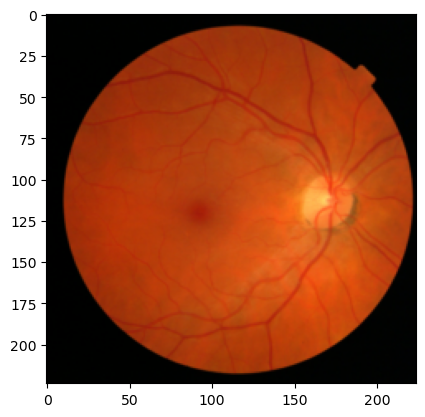

In [ ]:
# import torch
# from torch.utils.data import Dataset
# from torchvision import transforms
# from PIL import Image
# import os
# import pandas as pd
    
# def extract_center_square(image_path):
#     img = Image.open(image_path).convert('RGB')

#     width, height = img.size
#     size = height

#     left = (width - size) // 2
#     top = (height - size) // 2
#     right = (width + size) // 2
#     bottom = (height + size) // 2

#     center_square = img.crop((left, top, right, bottom))
#     return center_square

# class CustomDataset(Dataset):
#     def __init__(self, file_list_path, fold_path, transform=None):
#         self.file_list = self.load_file_list(file_list_path)
#         self.transform = transform

#     def load_file_list(self, file_list_path):
#         with open(file_list_path, 'r') as file:
#             file_list = [os.path.join('data', f) for f in file.read().splitlines()]
#         # print(file_list[:10])
#         return file_list

#     def __len__(self):
#         return len(self.file_list)

#     def __getitem__(self, idx):
#         img_path = self.file_list[idx]
#         img = extract_center_square(img_path)
#         if self.transform:
#             img = self.transform(img)
    
#         label = self.get_label_from_path(img_path)
#         return img, label

#     def get_label_from_path(self, img_path):
#         file_name = os.path.basename(img_path)
#         directory = os.path.dirname(img_path)
#         folder_name = os.path.basename(directory) # Base11...
#         df = pd.read_excel(f'{directory}/Annotation {folder_name}.xls')
        
#         return df.iloc[df[df['Image name'] == file_name].index, [2,3]].values[0]

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     # Add more transformations if necessary
# ])

# dataset = CustomDataset(file_list_path='data/file_list.txt', fold_path='data/10fold', transform=transform)
# # print(len(dataset))
# batch_size = 40  # Choose an appropriate batch size
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
# example = next(iter(dataloader))

# example[0].shape, example[1].shape

# image_pil = transforms.ToPILImage()(example[0][0])
# plt.imshow(image_pil)